In [3]:
"""
Author:   Gruppe 11
Member:   Paul Leonard Zens, Stefan Kaufmann
Date:     14.09.2022
Project:  Programmierübung Helirack

"""


#Wir importieren die benötigten Bibliotheken
import numpy as np
import scipy as sp
from libheli import plot_results
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import libmimo as mimo
import importlib as imp
import sympy

#Einfacher struct-Datentyp a la C oder Matlab
class struct:
    pass;

# 1 Modelle des Helikopters
## 1.1 Nichlineares Modell 
### 1.1.1. Modellgleichungen
$\newcommand{\vect}[1]{\boldsymbol{#1}}$
$\newcommand{\Vmax}{V_{\text{max}}}$

Drehimpulse in Abhängigkeit der Winkelgeschwindigkeiten lauten
\begin{align}
  p_\epsilon&=\bar J_3\dot{\epsilon}+J_5\omega_2,\quad \bar J_3=J_3+J_5\\
  p_\alpha&=(J_1+\bar J_2\cos^2(\epsilon))\dot\alpha+J_4 \cos(\epsilon)\omega_1,\quad \bar J_2=J_2+J_4.
\end{align}
Die Zeitableitungen der Drehimpulse lauten
\begin{align}
\dot p_\epsilon&=-\Vmax\cos (\epsilon)-\tfrac{1}{2}\bar J_2\sin(2\epsilon)\dot\alpha^2-J_4\,\omega_1\sin(\epsilon)\dot\alpha+ d_\epsilon  F_{\epsilon}-D_\epsilon\\
\dot p_\alpha&=d_\alpha \cos(\epsilon) F_{\alpha}-D_\alpha
\end{align}
Darin sind die Rotorkräfte durch 
\begin{equation}
  F_{\alpha}=s_\alpha|\omega_\alpha|\omega_\alpha,\quad F_{\epsilon}=s_\epsilon|\omega_\epsilon|\omega_\epsilon
\end{equation}
gegeben. Die Reibmomente lauten
\begin{equation}
  D_{\epsilon}=c_\epsilon\dot{\epsilon},\quad   D_{\alpha}=c_\alpha\dot{\alpha}
\end{equation}

Als Zustand wird nachfolgend der Vektor 
\begin{equation}
    \vect{x}=
    \begin{pmatrix}
      x_1\\
      x_2\\
      x_3
    \end{pmatrix}=
    \begin{pmatrix}
      \epsilon\\
      p_\alpha\\
      p_\epsilon
    \end{pmatrix}
\end{equation}
verwendet.
Der Ausgang ist durch den Elevationswinkel und die Azimut-Winkelgeschwindigkeit gegeben:
$$
  \vect{y}=(\epsilon,\dot\alpha)
$$
Zur Auswertung der Zustandsdifferentialgleichungen ist es sinnvoll, zunächst $\dot{x}_1=\dot{\epsilon}$ und $\dot{\alpha}$ 
zu berechnen und dann in die Gleichungen für $\dot{x}_2=\dot{p}_\alpha$ und $\dot{x}_3=\dot{p}_\epsilon$ einzusetzen.

In [4]:
#Modell prüfen
import libheli
imp.reload(libheli)

from libheli import Heli;

heli=Heli()
heli.verify_model("testdata.pckl")

Maximaler absoluter Fehler in Modellgleichung (euklidische Norm): 1.4210854715202004e-14
Maximaler relativer Fehler in Modellgleichung (euklidische Norm): 3.1650788331856327e-16
Maximaler absoluter Fehler in Ausgangsgleichung (euklidische Norm): 0.0
Maximaler relativer Fehler in Ausgangsgleichung (euklidische Norm): 0.0


In [5]:
#Interessierende Ruhelagen definieren
y1_equi=np.array([-1/18,0.5])*np.pi
y2_equi=np.array([1/18,0.25])*np.pi
y3_equi=np.array([1/18,10.0])*np.pi
y4_equi=np.array([0,0.375])*np.pi
y_equi=[y1_equi,y2_equi,y3_equi,y4_equi]

### 1.1.2. Simulation des nichtlinearen Modells

array([ 85.61596646, 285.91225663])

array([ 60.53963046, 341.43913814])

array([ 382.88624195, 3197.7807208 ])

array([ 73.58022723, 332.10558208])

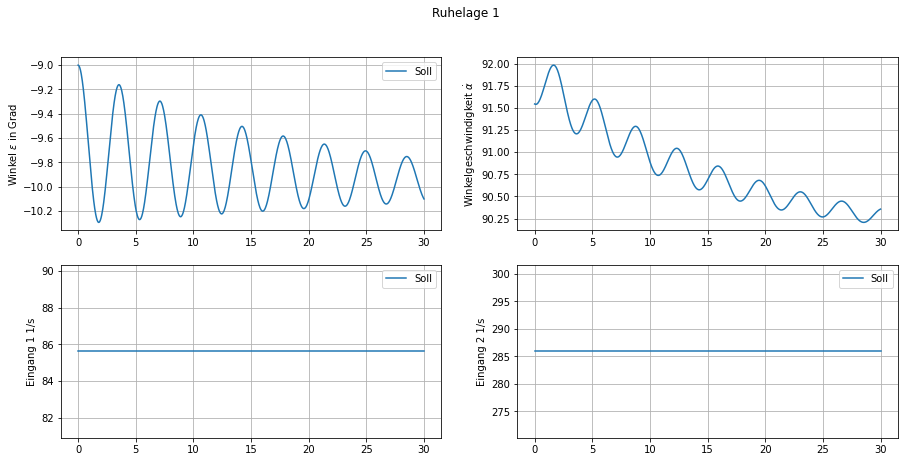

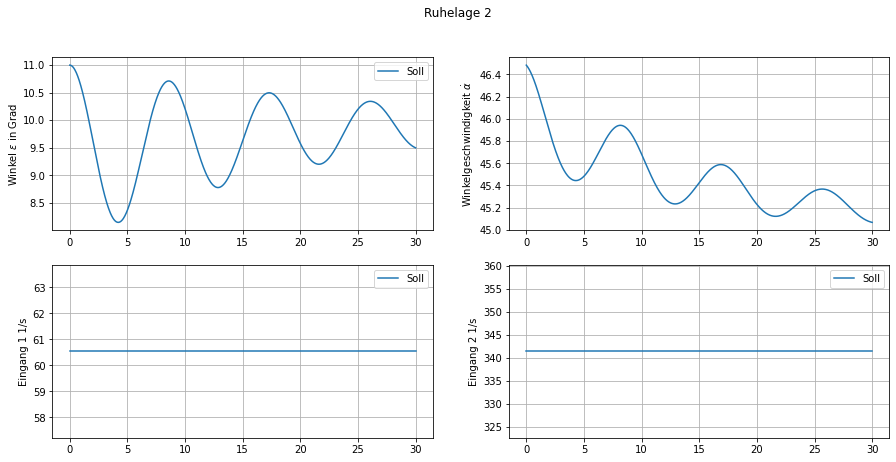

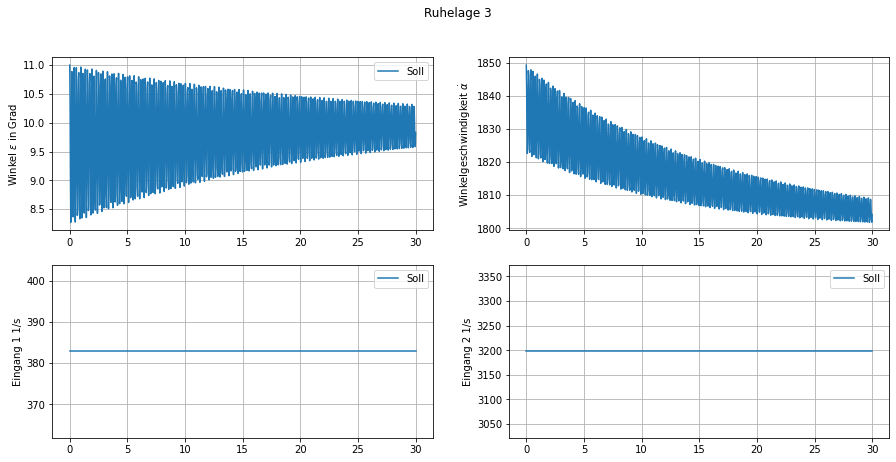

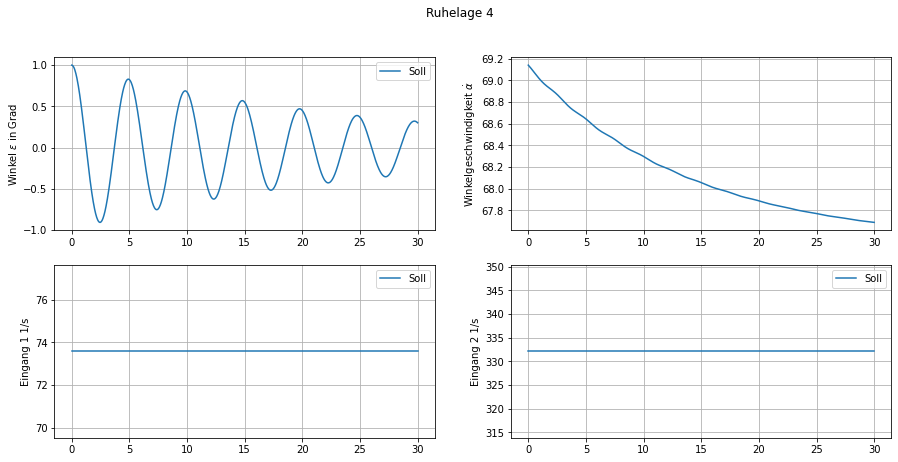

In [6]:
#Modell neu laden
import libheli
imp.reload(libheli)

from libheli import Heli;

heli=Heli()


#wrapper für Steuerung
def controller(t,x): 
    if x.ndim==1:
        return u0
    else:
        return np.diag(u0)@np.ones((2,x.shape[1]))

        
for i in range(len(y_equi)):
    y_=y_equi[i]
    
    #Ruhelage berechnen
    x0, u0=heli.equilibrium(y_)
    display(u0)
    #Anfangsfehler von 10Grad auf  
    x0[0]=x0[0]+np.pi/180
    x0[1]=x0[1]*1.02
    
    #Simulationszeit
    T_sim=30

    #Auswertungszeitpunkte 
    t_eval=np.linspace(0,T_sim,1000)

    #Wrapper für rechte Seite der Differentialgleichung
    rhs=lambda t,x:heli.model(t,x,controller)
    
    res = solve_ivp(rhs,#zu simulierendes Modell
                    [0,T_sim],#Zeitspanne für Simulation
                    x0,#Anfangszustand 
                    t_eval=t_eval,#Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6 #Toleranzen
                    )
    #Ergebnisse Plotten
    x=res.y
    u=controller(t_eval,x)
    y=heli.output(t_eval,x,controller)
    plot_results(t_eval,(x,),(u,),(y,))
    plt.gcf().suptitle('Ruhelage '+str(i+1))


## 1.2 Lineares Modell des Helikopters

##### Ruhelage:

Fügen Sie hier Ihre Überlegungen zu den Ruhelagen ein

##### Linearisierte Gleichungen
Fügen Sie hier Ihre Überlegungen zur Linearisierung des Modells ein

In [25]:
#Modell neu laden
import libheli
imp.reload(libheli)
import libmimo as mimo

from libheli import Heli;

heli=Heli()

#Analyse der Linearisierungen in den Ruhelagen
for i in range(len(y_equi)):
    y_=y_equi[i]
    
    #Berechnung der Linearisierung
    heli_lin=heli.linearize(y_)

    
    #Prüfen des Regimes
    x_equi,u_equi=heli.equilibrium(y_)
    #display(x_equi)
    #display(heli.model(0,x_equi,lambda t,x:u_equi))
    
    #Prüfen der Linearisierung
    #A,B,C=heli.verify_linearization(heli_lin)
    
    #Eigenwerte Berechnen
    print("------------------------------------------")
    print("Ruhelage"+str(i+1)+":")
    print("Eigenwerte")
    print(np.linalg.eigvals(heli_lin.A))

    #Steuerbarkeit und Kronecker-Indizes
    S=mimo.controllability_matrix(heli_lin.A,heli_lin.B)

    # Round
    r = 4

    print(" Steuerbarkeitsmatrix")
    #display(np.around(S,r))
    
    print("Rang der Steuerbarkeitsmatrix:")
    #display(np.linalg.matrix_rank(S))
    

    """
    Zur Berechnung der Kroneckerindizies wird, wie im Skriptum beschrieben, jede Spalte mit der links davon verglichen. Anschließend wird mittel der Funktion rank den Rang der Matrix, sprich ob die zwei Spalten linar Abhängig sind oder nicht überprüft.
    --> zwei Eingänge --> zwei Spaelten müssen linear unabhängig sein dies erhöht sich entsprechend den Eingängen
    Zur Implementierung müssen die MAtrixen noch gerundet werden. Dies ist notwendig, da diese nummersich Berechnet werden und so der implemtierung geschuldet immmer linear unabhägig sind. 

    """
    kronecker = np.array([],dtype=int)
    print("Mögliche Kroneckerindizes:")
    for i in range(1,np.size(S,1)):        
        if np.linalg.matrix_rank(np.around(S[:,i-1:i+1],r)) == np.size(B,1):
            kronecker = np.append(kronecker, i)
    display(kronecker)



    

# Arnf, Brnf, Crnf, M, Q, S = mimo.mimo_rnf(A, B, C, kronecker[0:2])
# display('Arnf: ', np.around(Arnf,r-2))
# display('Brnf: ', np.around(Brnf,r-2))
# display('Crnf: ', np.around(Crnf,r-2))
# display('M: ', np.around(M,r-2))
# display('Q: ', np.around(Q,r-2))

------------------------------------------
Ruhelage1:
Eigenwerte
[-0.04344196+1.75199274j -0.04344196-1.75199274j -0.06325162+0.j        ]
 Steuerbarkeitsmatrix
Rang der Steuerbarkeitsmatrix:
Mögliche Kroneckerindizes:


array([1, 2, 5])

------------------------------------------
Ruhelage2:
Eigenwerte
[-0.04748884+0.70431024j -0.04748884-0.70431024j -0.05515786+0.j        ]
 Steuerbarkeitsmatrix
Rang der Steuerbarkeitsmatrix:
Mögliche Kroneckerindizes:


array([1, 2, 5])

------------------------------------------
Ruhelage3:
Eigenwerte
[-0.04407914+32.15175775j -0.04407914-32.15175775j
 -0.06197727 +0.j        ]
 Steuerbarkeitsmatrix
Rang der Steuerbarkeitsmatrix:
Mögliche Kroneckerindizes:


array([1, 2, 3, 4, 5])

------------------------------------------
Ruhelage4:
Eigenwerte
[-0.03843198+1.25717456j -0.03843198-1.25717456j -0.07137759+0.j        ]
 Steuerbarkeitsmatrix
Rang der Steuerbarkeitsmatrix:
Mögliche Kroneckerindizes:


array([1, 2, 5])

# 2 Zeitkontinuierlicher Entwurf

In [8]:
#In diesem Abschnitt wird durchgehend die Ruhelage 5 für den Entwurf genutzt
heli_lin=heli.linearize(y4_equi)

#Übergangszeit ist jeweils 2 
T=2.0

## 2.1 Steuerungsentwurf 

y_equi [array([-0.17453293,  1.57079633]), array([0.17453293, 0.78539816]), array([ 0.17453293, 31.41592654]), array([0.        , 1.17809725])]
Vorgabe y_a:  [-0.17453293  1.57079633]
Vorgabe y_b:  [0.17453293 0.78539816]
ya:  [-0.17453293  1.57079633]
Trajektorie generieren


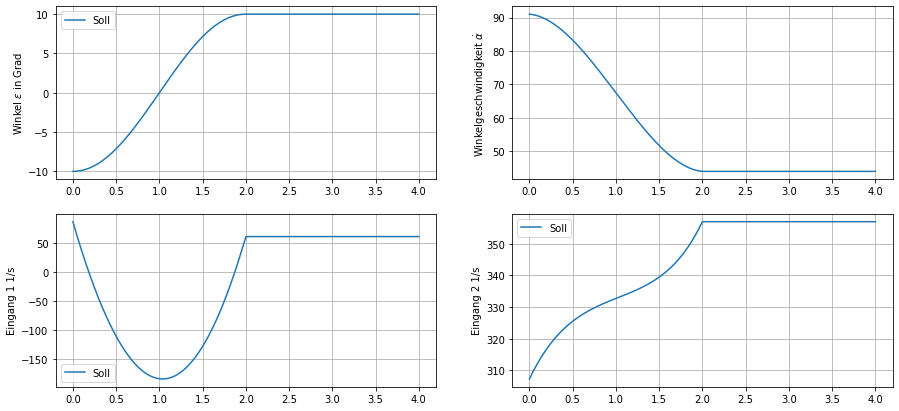

In [9]:
#importiere benötigte Funktion
imp.reload(libheli)

#Übergangszeit für Trajektorie
Tsim=2*T

#Generiere Solltrajektorien für das linearisierte System 
print('y_equi',y_equi)   # --> Gleichgewichtslagen
ya=np.array(y_equi[0])
yb=np.array(y_equi[1])
print('Vorgabe y_a: ', ya)
print('Vorgabe y_b: ', yb)
#yb[0]=yb[0]+1/18*np.pi
print('ya: ',ya)
print("Trajektorie generieren")
trajectory=heli_lin.rest_to_rest_trajectory(ya,yb,T,(1,2))

#Ergebnisse Plotten
tv=np.linspace(0,Tsim,1000)
x = trajectory.state(tv)
y = trajectory.output(tv)
u = trajectory.input(tv)
trajectory.A_rnf
plot_results(tv,(x,),(u,),(y,))


Zum Test der bisherigen Schritte wird die Planung mit der Simulation verglichen. Zumindest bei der Simulation mit dem linearen Modell sollten die geplanten und die simulierten Trajektorien jeweils übereinanderliegen.

### Simulation der Steuerung mit linearem Modell

Startwinkel:  -10.0


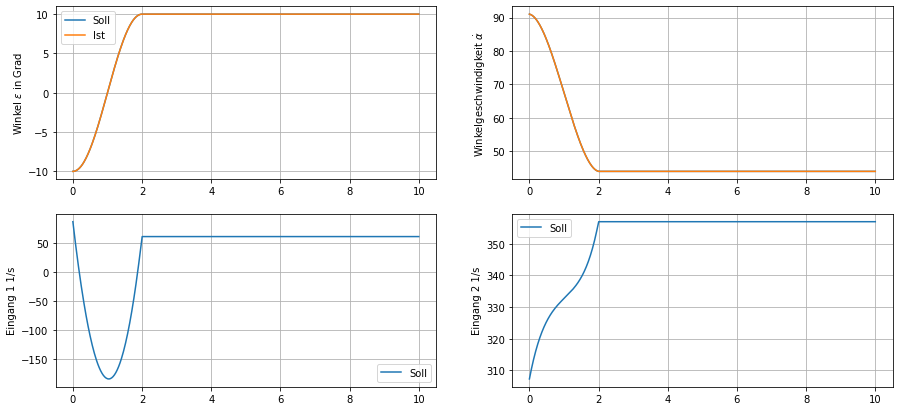

In [10]:
#Anfangszustand
x0=trajectory.state(0).flatten()
print('Startwinkel: ',x0[0]*180/np.pi)

#Simulationszeit
Tsim=10

#Auswertungszeitpunkte 
t_eval=np.linspace(0,Tsim,500)

# Wrapper für Steuerung
controller=lambda t,x:trajectory.input(t)

#Wrapper für rechte Seite der Differentialgleichung
rhs=lambda t,x:heli_lin.model(t,x,controller)

#Simlation
res = solve_ivp(rhs,#zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )
#Ergebnisse Plotten
x=res.y
a=plot_results(t_eval,
               (trajectory.state(t_eval),res.y),
               (trajectory.input(t_eval),),
               (trajectory.output(t_eval),heli_lin.output(t_eval,x,controller)))

### Simulation mit nichtlinearem Modell

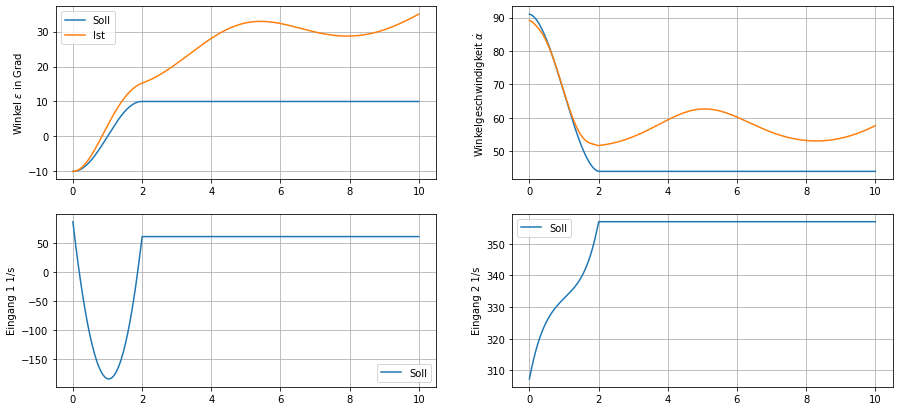

In [11]:
#Anfangszustand
x0,u0=heli.equilibrium(y1_equi)

#Simulationszeit
Tsim=10

#Auswertungszeitpunkte 
t_eval=np.linspace(0,Tsim,500)

# Wrapper für Steuerung
controller=lambda t,x:trajectory.input(t)

#Wrapper für rechte Seite der Differentialgleichung
rhs=lambda t,x:heli.model(t,x,controller)

#Simlation
res = solve_ivp(rhs,#zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )
#Ergebnisse Plotten
x=res.y
a=plot_results(t_eval,
               (trajectory.state(t_eval),res.y),
               (trajectory.input(t_eval),),
               (trajectory.output(t_eval),heli.output(t_eval,x,controller)))

## 2.2 Reglerentwurf mittels Eigenwertvorgabe 

In [12]:
# Definition einer generischen Zustandsrückführung mit Führungsgrößenaufschaltung
def controller_closed_loop(t,x,K,trajectory):
    tv=np.atleast_1d(t) 
    x_desired=trajectory.state(tv)
    #Dimension testen, eventuell auf Matrixform bringen
    if np.isscalar(t):
        x_=np.array(x).reshape(3,1)
    else:
        x_=x
    x_tilde=x_-x_desired
    u_desired=trajectory.input(tv)
    u=u_desired-K@x_tilde
    if np.isscalar(t):
        u=u[:,0]
    return u

### Berechnen der Reglerverstärkungen und Simulation des geschlossenen Regelkreises

In [13]:
#Eigenwerte des offenen Kreises
#Arnf=heli_lin.A
Arnf, Brnf, Crnf, M, Q, S  = mimo.mimo_rnf(heli_lin.A, heli_lin.B, heli_lin.C, (1,2))

eigs1=np.linalg.eigvals(Arnf[0:1,0:1])
eigs2=np.linalg.eigvals(Arnf[1:,1:])

display(sympy.Matrix(Arnf.round(3)))
display(sympy.Matrix(np.linalg.eigvals(Arnf)))

print("Eigenwerte offener Kreis entkoppeltes Teilsystem 1:")
display(sympy.Matrix(eigs1.round(3)))


print("Eigenwerte offener Kreis entkoppeltes Teilsystem 2:")
display(sympy.Matrix(eigs2.round(3)))

#Eigenwerte des geschlossenen Kreises

eigs1_cl = np.zeros_like(eigs1)
eigs2_cl = np.zeros_like(eigs2)

eigs1_cl[0]= -5        
eigs2_cl[0]= -10 -2j 
eigs2_cl[1]= -10 +2j


#Reglerstärkungen mit Ackermannformel bestimmen
K_pole_placement=np.zeros((2,3))#
K_pole_placement = heli_lin.acker([eigs1_cl,eigs2_cl])
display(K_pole_placement)

print("Reglerverstärkung:")
display(sympy.Matrix(K_pole_placement.round(3)))

print("Probe: Eigenwerte geschlossener Kreis")
display(sympy.Matrix(np.linalg.eigvals(heli_lin.A-heli_lin.B@K_pole_placement).round(3)))

print("Test: Eigenwerte Zielregime")
display(sympy.Matrix(np.linalg.eigvals(heli.linearize(y2_equi).A-heli.linearize(y2_equi).B@K_pole_placement).round(3)))

Matrix([
[-0.074,  0.035,      0],
[     0,      0,    1.0],
[ 0.109, -1.582, -0.074]])

Matrix([
[                     -0.0713775874375446],
[-0.0384319754035354 + 1.25717456118621*I],
[-0.0384319754035354 - 1.25717456118621*I]])

Eigenwerte offener Kreis entkoppeltes Teilsystem 1:


Matrix([[-0.074]])

Eigenwerte offener Kreis entkoppeltes Teilsystem 2:


Matrix([
[-0.037 + 1.257*I],
[-0.037 - 1.257*I]])

/home/stefan/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


array([[ 3.11940573e+00,  1.53930027e+05, -7.60186493e+02],
       [ 9.22340032e+03,  2.21626375e+05,  1.36767886e+05]])

Reglerverstärkung:


Matrix([
[ 3.119, 153930.027,   -760.186],
[9223.4, 221626.375, 136767.886]])

Probe: Eigenwerte geschlossener Kreis


Matrix([
[-10.0 + 2.0*I],
[-10.0 - 2.0*I],
[         -5.0]])

Test: Eigenwerte Zielregime


Matrix([
[-11.246],
[  -9.51],
[ -4.058]])

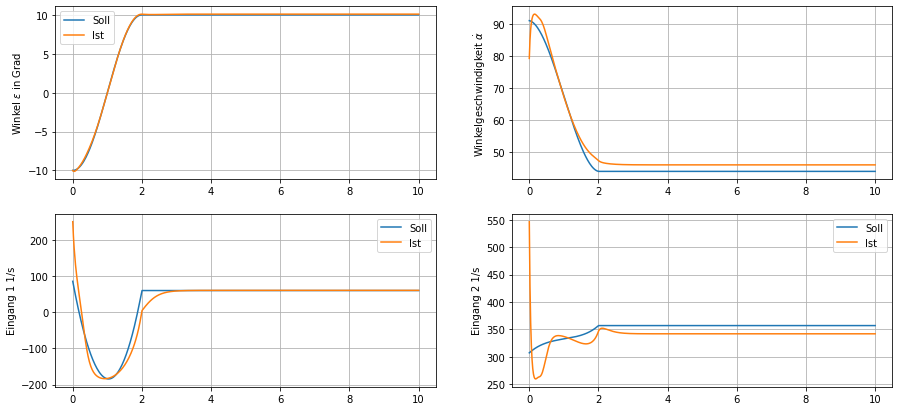

In [14]:
#Simulation mit linearem Entwurfsmodell oder nichtlinearem Modell?
linear = False

#Anfangszustand
Tsim=10

#Auswertungszeitpunkte 
t_eval=np.linspace(0,Tsim,500)

#Wrapper für Regler
controller = lambda t,x:controller_closed_loop(t,x,K_pole_placement,trajectory)


#Wrapper für Modell
if linear:
    rhs = lambda t,x:heli_lin.model(t,x,controller)
    x0 = trajectory.state(0)
else:
    rhs = lambda t,x:heli.model(t,x,controller)
    x0,u0=heli.equilibrium(y1_equi)
    #x0 = trajectory.state(0)
   
    

#Simulation
res = solve_ivp(rhs,#zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )
x_sim = res.y
u_sim = controller(t_eval,x_sim)
if linear:
    y_sim = heli_lin.output(t_eval,x_sim,controller)
else:
    y_sim = heli.output(t_eval,x_sim,controller)

    
#Ergebnisse Plotten
plot_results(t_eval,
             (trajectory.state(t_eval),x_sim),
             (trajectory.input(t_eval),u_sim),
             (trajectory.output(t_eval),y_sim))

## 2.3 LQR Entwurf

In [15]:
import libheli
imp.reload(libheli)
Q=np.eye(3) *100
R=np.eye(2) *1
S=np.zeros((3,2))


print("Gewichtsmatrix Q:")
display(sympy.Matrix(Q.round(3)))

print("Gewichtsmatrix R:")
display(sympy.Matrix(R.round(3)))

print("Kopplungsmatrix S:")
display(sympy.Matrix(S.round(3)))

K_lqr=heli_lin.lqr(Q,R,S)

print("Reglerverstärkung:")
display(sympy.Matrix(K_lqr.round(3)))

Gewichtsmatrix Q:


Matrix([
[100.0,     0,     0],
[    0, 100.0,     0],
[    0,     0, 100.0]])

Gewichtsmatrix R:


Matrix([
[1.0,   0],
[  0, 1.0]])

Kopplungsmatrix S:


Matrix([
[0, 0],
[0, 0],
[0, 0]])

Reglerverstärkung:


Matrix([
[-0.396, 0.022,  -0.385],
[  0.35, 0.001, 277.721]])

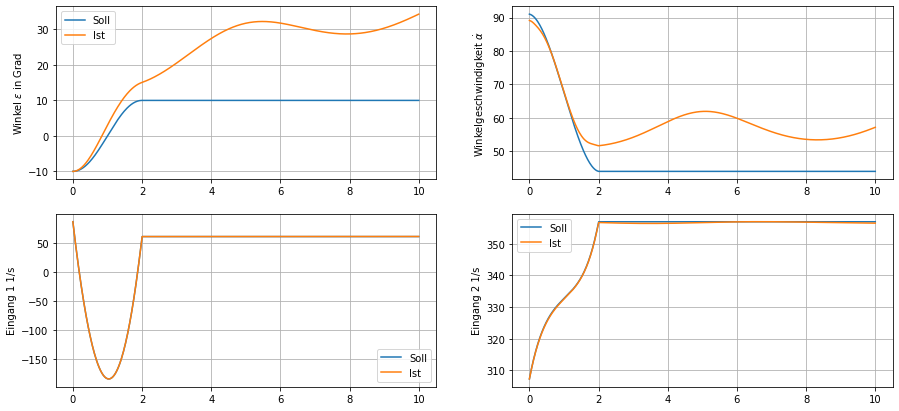

In [16]:
#Simulation mit linearem Entwurfsmodell oder nichtlinearem Modell?
linear = False

#Anfangszustand
Tsim=10

#Auswertungszeitpunkte 
t_eval=np.linspace(0,Tsim,500)

#Wrapper für Regler
controller = lambda t,x:controller_closed_loop(t,x,K_lqr,trajectory)


#Wrapper für Modell
if linear:
    rhs = lambda t,x:heli_lin.model(t,x,controller)
    x0 = trajectory.state(0)
else:
    rhs = lambda t,x:heli.model(t,x,controller)
    x0,u0=heli.equilibrium(y1_equi)
    

#Simulation
res = solve_ivp(rhs,#zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )
x_sim = res.y
u_sim = controller(t_eval,x_sim)
if linear:
    y_sim = heli_lin.output(t_eval,x_sim,controller)
else:
    y_sim = heli.output(t_eval,x_sim,controller)

    
#Ergebnisse Plotten
plot_results(t_eval,
             (trajectory.state(t_eval),x_sim),
             (trajectory.input(t_eval),u_sim),
             (trajectory.output(t_eval),y_sim))

# 3 Zeitdiskreter Entwurf
## 3.1 Zeitdiskretes Simulationsmodell
Das zeitdiskrete Simulationsmodell ist im wesentlichen als Schleife aufgebaut. In jedem Abtastschritt wird zunächst der Eingang aktualisiert. Im Anschluss wird das System, mit diesem Wert für den Eingang, über eine Abtastperiode simuliert.

In [17]:
def simulate_discrete(sys,x0,fkt_u,Ta,Tsim):
    #nonlinear simulation
    t_array=np.array([])
    u_array=np.zeros((2,0))
    x_array=np.zeros((len(x0),0))
    k=0
    while k*Ta<Tsim:
        u=fkt_u(k,x0)
        ctrl = lambda t,x:u
        rhs=lambda t,x:sys(t,x,ctrl)
        t_eval=[k*Ta,(k+0.01)*Ta,(k+0.99)*Ta,(k+1)*Ta]
        res=solve_ivp(rhs,[k*Ta,(k+1)*Ta],x0,atol=1e-9,rtol=1e-6,t_eval=t_eval)
        t_array=np.hstack((t_array,res.t))
        x_array=np.hstack((x_array,res.y))
        u_array=np.hstack((u_array,u.reshape((2,1))*np.ones_like(res.t)))
        k+=1
        x0=x_array[:,-1]

    return t_array,x_array,u_array

Für alle nachfolgenden zeitdiskreten Schritte muss zunächst das Systemmodell mit der gewählten Abtastschrittweite $T_a$ diskretisiert werden.

## 3.2 Quasi-kontinuierliche Simulation

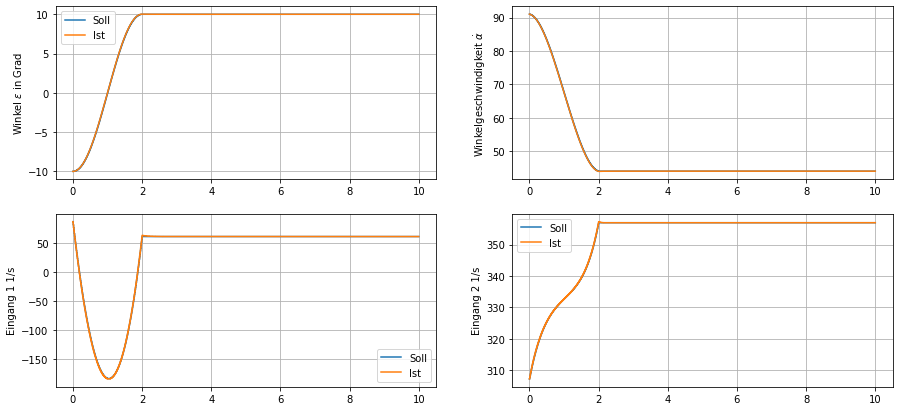

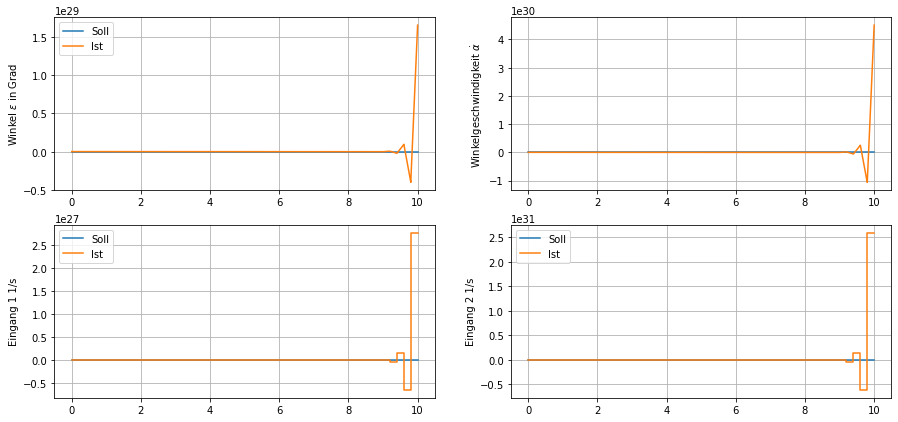

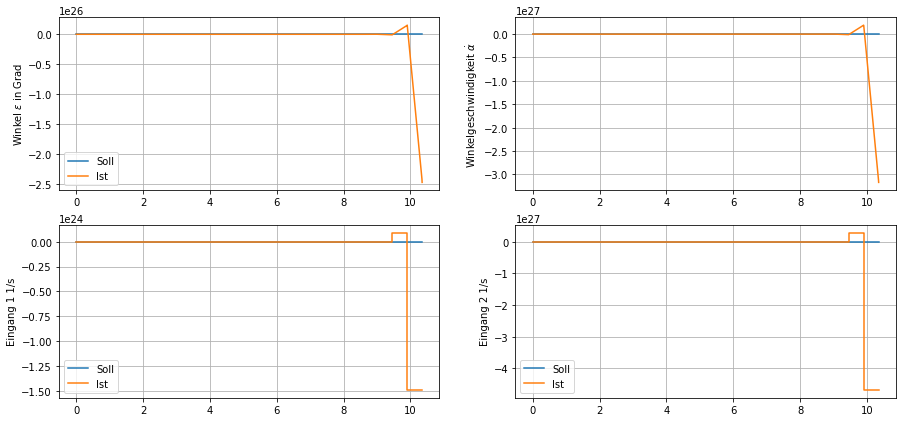

In [18]:
#Abtastzeiten
Ta_v = [0.01, 0.2, 0.45]

#Simulationszeit
Tsim=10

#Simulation mit linearem Entwurfsmodell oder nichtlinearem Modell?
linear = True

#Auswertungszeitpunkte 
t_eval=np.linspace(0,Tsim,500)

   
for Ta in Ta_v:
    #Anfangszustand
    x0,u0=heli.equilibrium(y1_equi)

    
    #Wrapper für Modell
    x0 = trajectory.state(0)
    
    #Wrapper für Modell
    if linear:
        rhs = lambda t,x,controller:heli_lin.model(t,x,controller)
        x0 = trajectory.state(0)
    else:
        rhs = lambda t,x,controller:heli.model(t,x,controller)
        x0,u0=heli.equilibrium(y1_equi)

    #Wrapper für Regler
    controller = lambda k_,x_:controller_closed_loop(k_*Ta,x_,K_pole_placement,trajectory)

    #Zeitdiskrete Simulation
    t_sim,x_sim,u_sim=simulate_discrete(rhs,x0,controller,Ta,Tsim)

    #Ergebnisse Plotten
    x_desired=trajectory.state(t_sim)
    u_desired=trajectory.input(np.floor(t_sim/Ta)*Ta)
    y_desired=trajectory.output(np.floor(t_sim/Ta)*Ta)
    
    if linear:
        y_sim = heli_lin.output(np.round(t_sim/Ta),x_sim,controller)
    else:
        y_sim = heli.output(np.round(t_sim/Ta),x_sim,controller)
   
    
    plot_results(t_sim,
                 (x_desired,x_sim),
                 (u_desired,u_sim),
                 (y_desired,y_sim))

## 3.3 Zeitdiskreter Steuerungsentwurf

Anfangs und Endwerte flacher Ausgang:
[1707.11146383 -790.70054427]
[-1707.11146383   790.70054427]
Anfangs und Endwerte flacher Ausgang:
[349.60393796 -29.13178215]
[-349.60393796   29.13178215]


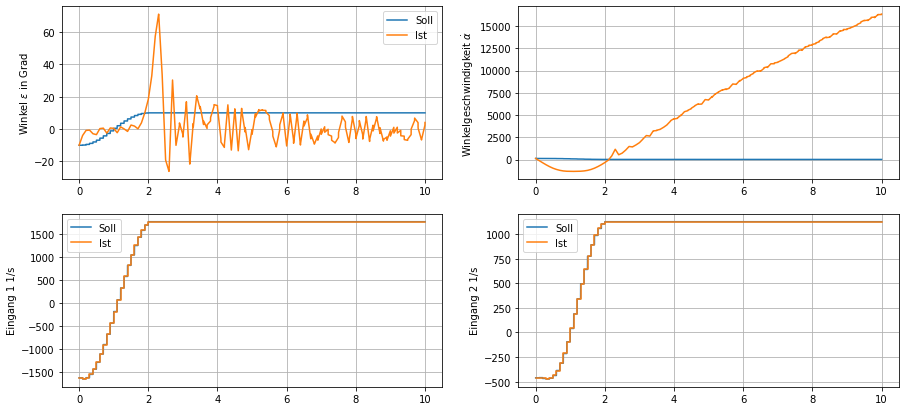

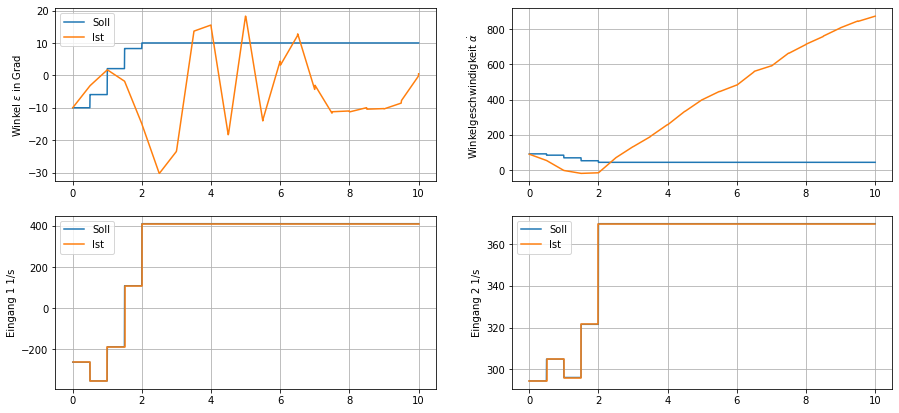

In [19]:
Ta_v=[0.1,0.5]

#Übergangszeit
T=2.0

#Simulationszeit
Tsim=10

linear=False

for Ta in Ta_v:
    #Schritte für Übergang
    N=np.round(T/Ta)

    #diskretes Modell
    heli_lin_discrete = heli_lin.discretize(Ta)

    #Berechne diskrete Solltrajektorien 
    trajectory_discrete = heli_lin_discrete.rest_to_rest_trajectory(y1_equi,y2_equi,N,[1,2])

    controller = lambda k,x:trajectory_discrete.input(k)
    
    print("Anfangs und Endwerte flacher Ausgang:")
    print(trajectory_discrete.eta_a)
    print(trajectory_discrete.eta_b)

    #Wrapper für Modell
    if linear:
        rhs = lambda t,x,controller:heli_lin.model(t,x,controller)
        x0=trajectory_discrete.state(0)
    else:
        rhs = lambda t,x,controller:heli.model(t,x,controller)
        x0,u0=heli.equilibrium(y1_equi)
        

    #Zeitdiskrete Simulation
    t_sim,x_sim,u_sim=simulate_discrete(rhs,x0,controller,Ta,Tsim)

    #Ergebnisse Plotten
    x_desired=trajectory_discrete.state(np.floor(t_sim/Ta))
    u_desired=trajectory_discrete.input(np.floor(t_sim/Ta))
    y_desired=trajectory_discrete.output(np.floor(t_sim/Ta))
    
    if linear:
        y_sim = heli_lin.output(t_sim,x_sim,lambda t,x:controller(np.round(t_sim/Ta),x))
    else:
        y_sim = heli.output(t_sim,x_sim,lambda t,x:controller(np.round(t_sim/Ta),x))
   
    
    plot_results(t_sim,
                  (x_desired,x_sim),
                  (u_desired,u_sim),
                  (y_desired,y_sim))
    # plot_results(t_sim,
    #              (x_desired,x_desired),
    #              (u_desired,u_desired),
    #              (y_desired,y_desired))

## 3.4. Zeitdiskreter Reglerentwurf

In [20]:
# Definition einer generischen diskreten Zustandsrückführung mit Führungsgrößenaufschaltung
def control_discrete_closed_loop(k,x,Kd,trajectory):
    kv=np.atleast_1d(k) 
    x_desired=trajectory.state(kv)
    #Dimension testen, eventuell auf Matrixform bringen
    if np.isscalar(k):
        x_=np.array(x).reshape(3,1)
    else:
        x_=x
    x_tilde=x_-x_desired
    u_desired=trajectory.input(kv)
    u=u_desired-Kd@x_tilde
    if np.isscalar(k):
        u=u[:,0]
    return u

array([[ 3.11940573e+00,  1.53930027e+05, -7.60186493e+02],
       [ 9.22340032e+03,  2.21626375e+05,  1.36767886e+05]])

Anfangs und Endwerte flacher Ausgang:
[1707.11146383 -790.70054427]
[-1707.11146383   790.70054427]


array([[ 3.11940573e+00,  1.53930027e+05, -7.60186493e+02],
       [ 9.22340032e+03,  2.21626375e+05,  1.36767886e+05]])

Anfangs und Endwerte flacher Ausgang:
[349.60393796 -29.13178215]
[-349.60393796   29.13178215]


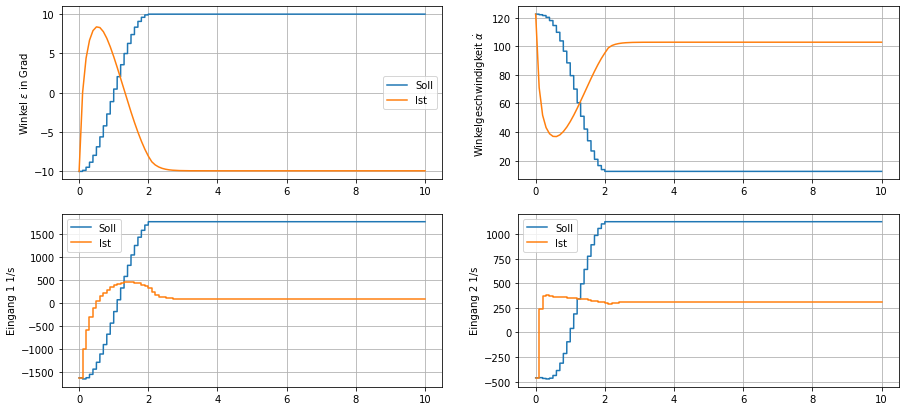

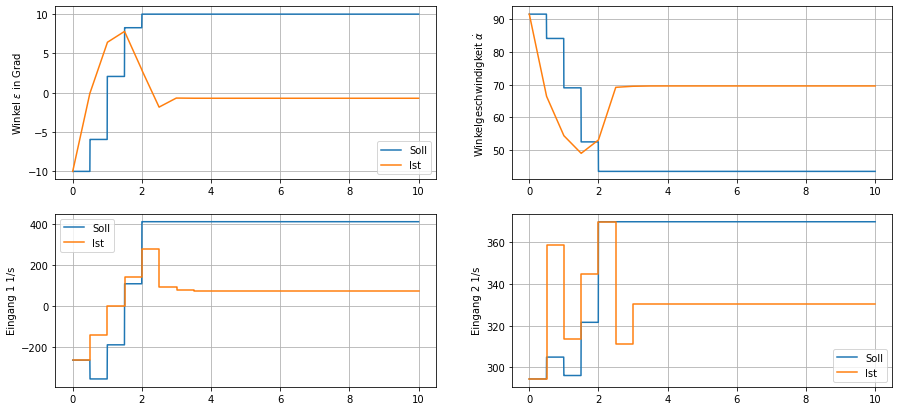

In [21]:
Ta_v=[0.1,0.5]

#Übergangszeit
T=2.0

#Simulationszeit
Tsim=10

linear=True

for Ta in Ta_v:
    #Schritte für Übergang
    N=np.round(T/Ta)

    #diskretes Modell
    heli_lin_discrete = heli_lin.discretize(Ta)

   
    #Wunschpolynom geschlossener Regelkreis      
    eigsd_1 = np.exp(eigs1_cl*Ta)                # discrete#
    eigsd_2 = np.exp(eigs2_cl*Ta) 
       

    #Ackermannformel auswerten
    Kd_pole_placement=np.zeros((2,3))      #heli_lin_discrete.acker(eigsd)
    Kd_pole_placement = heli_lin_discrete.acker([eigsd_1, eigsd_2])    
    display(K_pole_placement)



    #Berechne diskrete Solltrajektorien 
    trajectory_discrete = heli_lin_discrete.rest_to_rest_trajectory(y1_equi,y2_equi,N,[1,2])

    controller = lambda k,x:control_discrete_closed_loop(k,x,Kd_pole_placement,trajectory_discrete)

    print("Anfangs und Endwerte flacher Ausgang:")
    print(trajectory_discrete.eta_a)
    print(trajectory_discrete.eta_b)
    
    #Wrapper für Modell
    if linear:
        rhs = lambda t,x,controller:heli_lin.model(t,x,controller)
        x0=trajectory_discrete.state(0)
    else:
        rhs = lambda t,x,controller:heli.model(t,x,controller)
        x0,u0=heli.equilibrium(y1_equi)
        

    #Zeitdiskrete Simulation
    t_sim,x_sim,u_sim=simulate_discrete(rhs,x0,controller,Ta,Tsim)

    #Ergebnisse Plotten
    x_desired=trajectory_discrete.state(np.floor(t_sim/Ta))
    u_desired=trajectory_discrete.input(np.floor(t_sim/Ta))
    y_desired=trajectory_discrete.output(np.floor(t_sim/Ta))
    
    if linear:
        y_sim = heli_lin.output(t_sim,x_sim,lambda t,x:controller(np.round(t_sim/Ta),x))
    else:
        y_sim = heli.output(t_sim,x_sim,lambda t,x:controller(np.round(t_sim/Ta),x))
   
    
    plot_results(t_sim,
                 (x_desired,x_sim),
                 (u_desired,u_sim),
                 (y_desired,y_sim))

Anfangs und Endwerte flacher Ausgang:
[1707.11146383 -790.70054427]
[-1707.11146383   790.70054427]
Anfangs und Endwerte flacher Ausgang:
[349.60393796 -29.13178215]
[-349.60393796   29.13178215]


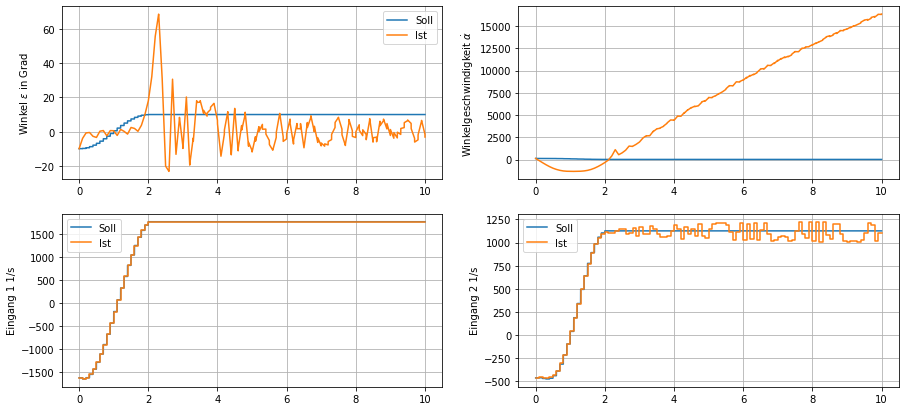

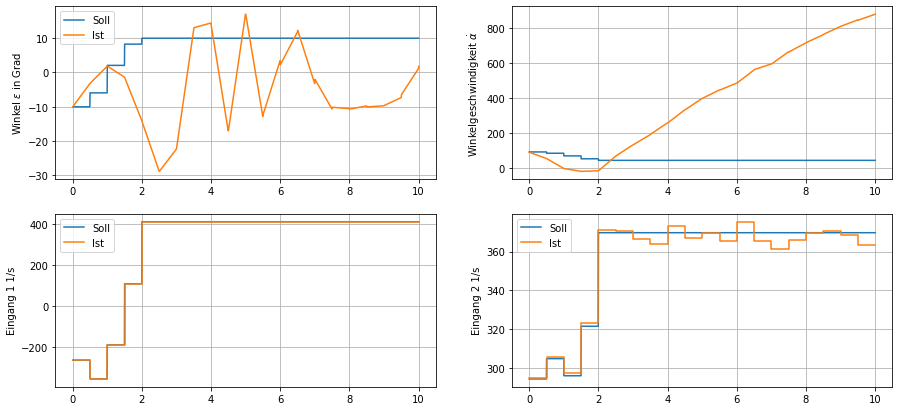

In [22]:
Ta_v=[0.1,0.5]

#Übergangszeit
T=2.0

#Simulationszeit
Tsim=10

linear=False

for Ta in Ta_v:
    #Schritte für Übergang
    N=np.round(T/Ta)

    #diskretes Modell
    heli_lin_discrete = heli_lin.discretize(Ta)

    #LQR auswerten
    Kd_lqr=heli_lin_discrete.lqr(Q,R,S)

    #Berechne diskrete Solltrajektorien 
    trajectory_discrete = heli_lin_discrete.rest_to_rest_trajectory(y1_equi,y2_equi,N,[1,2])

    controller = lambda k,x:control_discrete_closed_loop(k,x,Kd_lqr,trajectory_discrete)

    print("Anfangs und Endwerte flacher Ausgang:")
    print(trajectory_discrete.eta_a)
    print(trajectory_discrete.eta_b)
    
    #Wrapper für Modell
    if linear:
        rhs = lambda t,x,controller:heli_lin.model(t,x,controller)
        x0=trajectory_discrete.state(0)
    else:
        rhs = lambda t,x,controller:heli.model(t,x,controller)
        x0,u0=heli.equilibrium(y1_equi)
        

    #Zeitdiskrete Simulation
    t_sim,x_sim,u_sim=simulate_discrete(rhs,x0,controller,Ta,Tsim)

    #Ergebnisse Plotten
    x_desired=trajectory_discrete.state(np.floor(t_sim/Ta))
    u_desired=trajectory_discrete.input(np.floor(t_sim/Ta))
    y_desired=trajectory_discrete.output(np.floor(t_sim/Ta))
    
    if linear:
        y_sim = heli_lin.output(t_sim,x_sim,lambda t,x:controller(np.round(t_sim/Ta),x))
    else:
        y_sim = heli.output(t_sim,x_sim,lambda t,x:controller(np.round(t_sim/Ta),x))
   
    
    plot_results(t_sim,
                 (x_desired,x_sim),
                 (u_desired,u_sim),
                 (y_desired,y_sim))